# Semantic Segmentation of Water using U-Net
# Part 5 - Training with Data Augmentation


In this part I will train a CNN using data augmentation and evaluate the effect of this strategy.

In [1]:
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import concatenate, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, save_img
import numpy as np
import json, os
from random import shuffle
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import warnings
import re
import time

In [2]:
from unetlib.preprocessing import get_lakes_with_masks, make_dataframes_for_flow, make_data_generators
import unetlib.visualisation as vs

In [3]:
# Imagery directories
nwpu_data_dir = 'nwpu_lake_images/data/'
nwpu_mask_dir = 'nwpu_lake_images/masks/'

## Set Up Training & Validation Data

In [4]:
# Split the test/train data
train_img_df, train_msk_df, test_img_df, test_msk_df, = make_dataframes_for_flow(nwpu_data_dir,
                                                                                 nwpu_mask_dir,
                                                                                 test_split=0.25,
                                                                                 random_state=42
                                                                                )

In [5]:
# Split the training data into train and validation generators
# with augmentation applied to the training data only
aug_dict = {'rotation_range':90,
            'horizontal_flip':True,
            'vertical_flip':True,
            'width_shift_range':0.15,
            'height_shift_range':0.15,
            'zoom_range':0.25
           }

batch_size = 16

train_gen, val_gen, train_fps, val_fps = make_data_generators(train_img_df, train_msk_df,
                                                              nwpu_data_dir, nwpu_mask_dir,
                                                              val_split=0.3,
                                                              batch_size=batch_size,
                                                              aug_dict=aug_dict,
                                                              aug_seed=42)

Found 210 validated image filenames.
Found 210 validated image filenames.
Found 90 validated image filenames.
Found 90 validated image filenames.


## Set Up Model

In [6]:
from unetlib.model import UNet
from unetlib.metrics import BinaryMeanIoU

In [7]:
# Same configuration as baseline model from part 3
model = UNet(n_filters=32, n_blocks=2, model_name='augmented')
model.summary()

Model: "augmented_f32_b2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 32) 0           conv2d_1[0][0]                   
___________________________________________________________________________________

In [8]:
# Compile the model
model.compile(optimizer='RMSProp',
              loss='binary_crossentropy',
              metrics=[BinaryMeanIoU(threshold=0.5)]
             )

In [9]:
# Compute steps per epoch
train_steps = int(np.ceil(len(train_fps) / batch_size))
val_steps = int(np.ceil(len(val_fps) / batch_size))

print(f'Train Steps: {train_steps}')
print(f'Val Steps: {val_steps}')

Train Steps: 14
Val Steps: 6


## Train Model

In [10]:
# Number of times to cycle the full training set
epochs = 100

In [ ]:
# Train the model and record the time taken
    
t1 = time.time()
history = model.fit(train_gen, epochs=epochs, steps_per_epoch=train_steps,
                    validation_data=val_gen, validation_steps=val_steps)
runtime = time.time() - t1

# How many minutes did training take?
print(runtime / 60)

In [ ]:
# configure model output directory and filenames
output_dir = 'model_outputs'
os.makedirs(output_dir, exist_ok=True)

hist_filepath = os.path.join(output_dir,
                             f'{model.name}_bs{batch_size}e{epochs}.history.pickle')

weights_filepath = os.path.join(output_dir,
                                f'{model.name}_bs{batch_size}e{epochs}.weights.h5')

In [ ]:
# Save history to pickle
with open(hist_filepath, 'wb') as f:
    pickle.dump(history.history, f)
    
# Save model weights
model.save_weights(weights_filepath)

## Evaluate Model

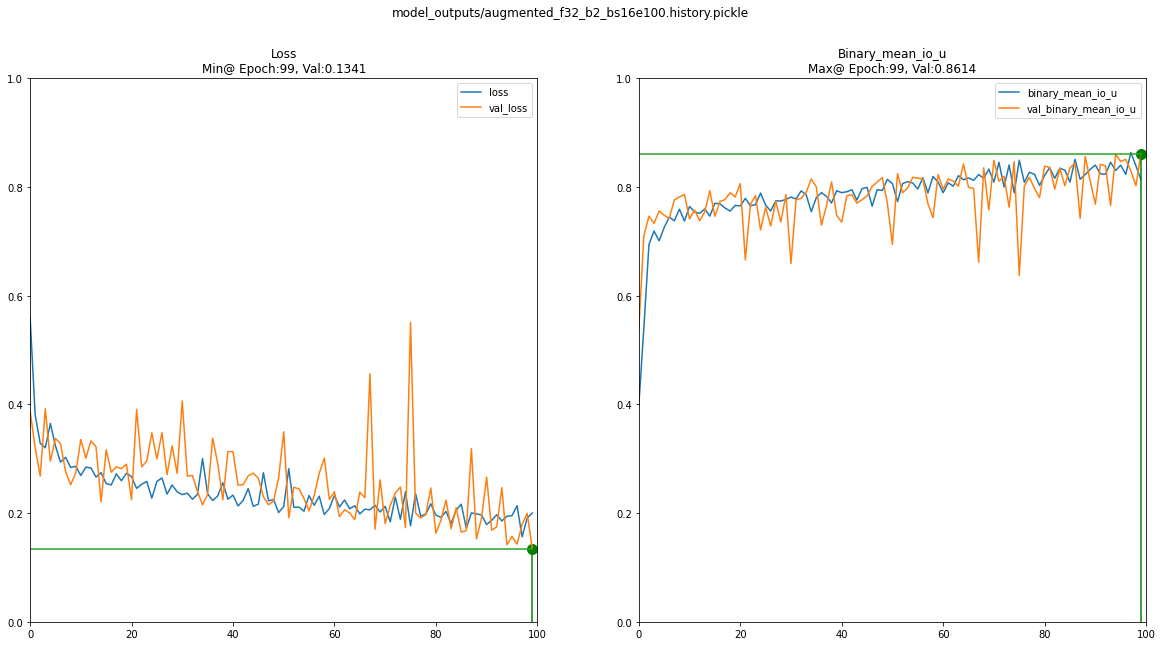

In [11]:
# Load history if not already available
aug1_hist_filepath = 'model_outputs/augmented_f32_b2_bs16e100.history.pickle'
with open(aug1_hist_filepath, 'rb') as f:
    aug1_hist = pickle.load(f)

# Create dataframe of history
aug1_hist_df = pd.DataFrame(aug1_hist)

# Plot history
vs.plot_model_history(aug1_hist_df, metrics=['loss', 'binary_mean_io_u'],
                      best=['min', 'max'], title=aug1_hist_filepath);

In [12]:
# Create results dataframe
columns = ['Filepath', 'Filters', 'Blocks', 'Batch Size', 'Epochs', 'Val Loss', 'Val IoU']

aug1_results = [os.path.basename(aug1_hist_filepath), 32, 2, 16, 100,
                    aug1_hist_df.val_loss.min(),
                    aug1_hist_df.at[aug1_hist_df.val_loss.argmin(),
                                        'val_binary_mean_io_u']
                   ]

results = pd.DataFrame(data=[aug1_results], columns=columns)
results

,Filepath,Filters,Blocks,Batch Size,Epochs,Val Loss,Val IoU
0,augmented_f32_b2_bs16e100.history.pickle,32,2,16,100,0.134053,0.861437


The baseline model achieved a Val Loss of 0.1365 and Val IoU:0.8674. Here I have achieved a better loss than the baseline but a slighly worse Val IoU. Importantly though, there is no evidence of overfitting the data. Therefore the model still has potential to improve during training. Therefore, I'll increase the epochs to let the model run for longer and see how training progresses.

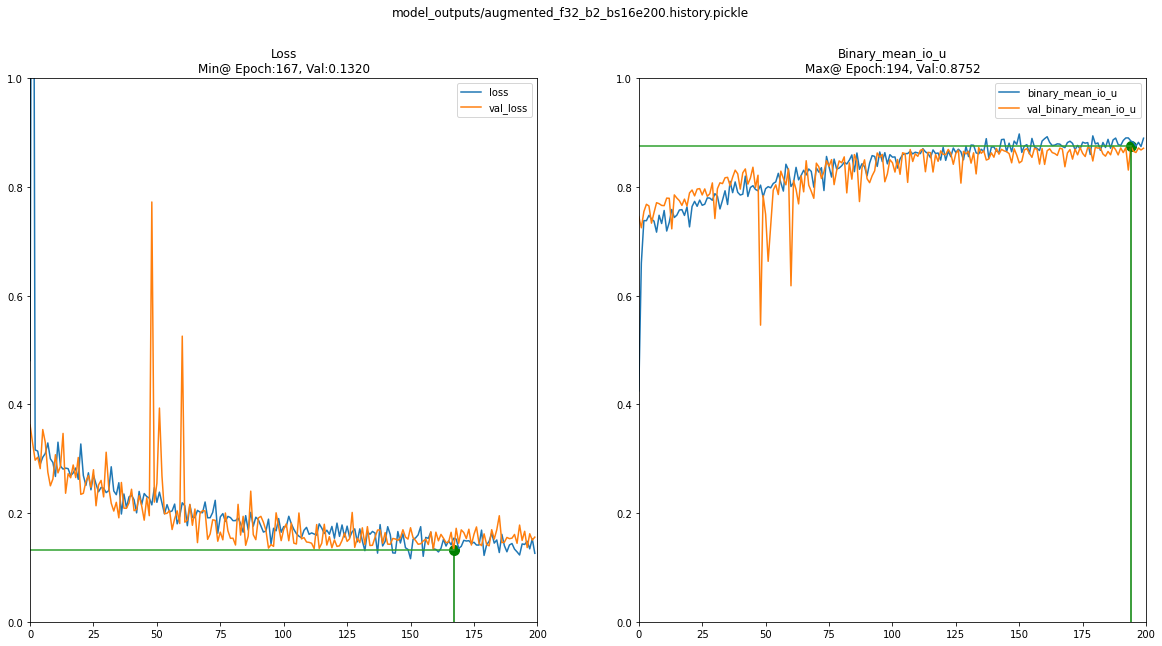

In [13]:
# Load history if not already available
aug2_hist_filepath = 'model_outputs/augmented_f32_b2_bs16e200.history.pickle'
with open(aug2_hist_filepath, 'rb') as f:
    aug2_hist = pickle.load(f)

# Create dataframe of history
aug2_hist_df = pd.DataFrame(aug2_hist)

# Plot history
vs.plot_model_history(aug2_hist_df, metrics=['loss', 'binary_mean_io_u'],
                      best=['min', 'max'], title=aug2_hist_filepath);

In [14]:
aug2_results = [os.path.basename(aug2_hist_filepath), 32, 2, 16, 200,
                aug2_hist_df.val_loss.min(),
                aug2_hist_df.at[aug2_hist_df.val_loss.argmin(),
                                'val_binary_mean_io_u']
               ]

results = results.append({k:v for k,v in zip(columns, aug2_results)}, ignore_index=True)
results

,Filepath,Filters,Blocks,Batch Size,Epochs,Val Loss,Val IoU
0,augmented_f32_b2_bs16e100.history.pickle,32,2,16,100,0.134053,0.861437
1,augmented_f32_b2_bs16e200.history.pickle,32,2,16,200,0.132015,0.869757


With more epochs, the model reaches better Val Loss and Val IoU values. Again, the model clearly shows no signs of overfitting but it's performance is reaching a plateau. This is a sign that the model is reaching its learning capacity and training longer, i.e. more epochs, would likely not lead to a significant improvement in performance. Instead, a more powerful model should be used.

I will focus on this in the next notebook.